In [1]:
"""
Follows https://www.tensorflow.org/tutorials/text/text_classification_rnn
"""
import pickle as pkl
import numpy as np
import random
import re

import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
from datetime import datetime
datetime.now()

datetime.datetime(2020, 12, 16, 15, 46, 17, 554957)

In [3]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_" + metric])


In [4]:
def split_data_into_input_and_output(data):
    """Take given data of format from scraper [link] and return the inputs and outputs seperated.

    Args:
        data (list): A numpy array/list of named tuples which contains entries for 'gross',
        'title', 'synopsis' and 'year'.
    """
    data_in, data_out = list(zip(*[((x["synopsis"]), x["gross"]) for x in data]))
    return np.array(data_in), np.array(data_out)

In [5]:
def add_signal(data):
    """
    If the given data has no signal we cant fit a NN to it. As such, here we append how much the film grossed
    into the synopsis of each title.

    Args:
        data (list): A numpy array/list of named tuples which contains entries for 'gross',
        'title', 'synopsis' and 'year'.
    """
    for row in data:
        row["synopsis"] = row["synopsis"] + f' The film grossed ${row["gross"]}'

In [6]:
real_data = pkl.load(open("complete10000_films_and_synopsis.pickle", "rb"))
data = real_data[:1000]
np.random.shuffle(data)

In [7]:
# Fraction of overall data
training_fraction = 0.85
# Fraction of training data
validation_fraction = 0.2

train_end = int(len(data) * training_fraction)
train_data_in, train_data_out = split_data_into_input_and_output(data[:train_end])
test_data_in, test_data_out = split_data_into_input_and_output(data[train_end:])

train_dataset = tf.data.Dataset.from_tensor_slices((train_data_in, train_data_out))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_in, test_data_out))


# How much it loads into memory for sampling
BUFFER_SIZE = 10000
# Batch for gradient averaging
BATCH_SIZE = 64
# prefetch parrallelising loading + execution (not huge so not necessary)

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(5)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(5)

In [8]:
sample, label = next(iter(train_dataset.take(1)))

In [9]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE, ngrams=1
)


In [10]:
encoder.adapt(train_dataset.map(lambda text, label: text))

In [11]:
encoded_sample = encoder(sample).numpy()[:3]
print(encoded_sample)

[[   3 2102 3256    6    9  978  156 4420 2425  287    6    8 4778 1111
     4    8  697   69    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   7    2 3280 3493  895  398   30    2  840   38    3 4212   26  103
    36   14    9  773  277   31   28  364   23  215  485 2011 1740    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   2   72    6  522 4293    3 3581 2409  380    3 3700 1608 3151   23
    42  465 4310    3 3556    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]


In [12]:
vocab = np.array(encoder.get_vocabulary())

for n in range(3):
  print("Original: ", sample[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_sample[n]]))
  print()

Original:  b'The aging patriarch of an organized crime dynasty transfers control of his clandestine empire to his reluctant son.'
Round-trip:  the aging patriarch of an organized crime dynasty transfers control of his clandestine empire to his reluctant son                          

Original:  b"In a parallel modern-day Stone Age world, a working-class family, the Flintstones, are set up for an executive job. But they learn that money can't buy happiness."
Round-trip:  in a parallel modernday stone age world a workingclass family the flintstones are set up for an executive job but they learn that money cant buy happiness                 

Original:  b'A group of scientists exploring the Marianas Trench encounter the largest marine predator that has ever existed - the Megalodon.'
Round-trip:  a group of scientists exploring the marianas trench encounter the largest marine predator that has ever existed the megalodon                         



In [13]:
model = tf.keras.Sequential(
    [
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()), output_dim=64, mask_zero=True
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(1),
)

In [14]:
history = model.fit(
    train_dataset, epochs=10
)

Epoch 1/10
14/14 [==============================] - 1s 54ms/step - loss: 34695746544467968.0000
Epoch 2/10
14/14 [==============================] - 1s 53ms/step - loss: 34360990350966784.0000
Epoch 3/10
14/14 [==============================] - 1s 53ms/step - loss: 33030667180703744.0000
Epoch 4/10
14/14 [==============================] - 1s 53ms/step - loss: 30053967081766912.0000
Epoch 5/10
14/14 [==============================] - 1s 53ms/step - loss: 25273524599914496.0000
Epoch 6/10
14/14 [==============================] - 1s 53ms/step - loss: 19590183355678720.0000
Epoch 7/10
14/14 [==============================] - 1s 52ms/step - loss: 14230086718849024.0000
Epoch 8/10
14/14 [==============================] - 1s 52ms/step - loss: 10884740986961920.0000
Epoch 9/10
14/14 [==============================] - 1s 54ms/step - loss: 9839648742309888.0000
Epoch 10/10
14/14 [==============================] - 1s 53ms/step - loss: 9471708557737984.0000


In [15]:
res = model.evaluate(test_dataset)

3/3 [==============================] - 0s 10ms/step - loss: 13766699476058112.0000


In [16]:
sample_text = "As a new threat to the galaxy rises, Rey, a desert scavenger, and Finn, an ex-stormtrooper, must join Han Solo and Chewbacca to search for the one hope of restoring peace."
pred1 = model.predict(np.array([sample_text]))
print(int(pred1[0]))

146442464


In [17]:
non_existant_film = "Este is a friend of mine we meet up every tuesday night for dinner and a glass of wine. She thinks he did it but just cant prove it"
pred2 = model.predict(np.array([non_existant_film]))
print(int(pred2[0]))

146749824


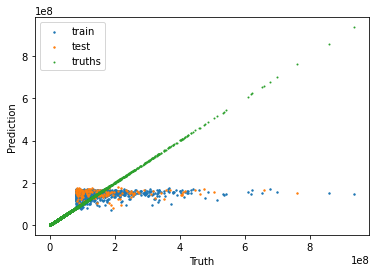

In [19]:
test_predictions = model.predict(test_data_in)
train_predictions = model.predict(train_data_in)
plt.scatter(train_data_out, train_predictions, label='train', s=2)
plt.scatter(test_data_out, test_predictions, label='test', s=2)
plt.scatter(real_data['gross'], real_data['gross'], label='truths', s=1)
plt.legend()
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.show()